In [1]:
from __future__ import print_function
import os
import numpy as np
from time import time
import logging
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from six.moves import zip
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
print(__doc__)

Automatically created module for IPython interactive environment


In [24]:
def plot_gallery(images, titles, h, w, n_row = 6, n_col = 6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize = (1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left = .01, right=.99, top = .90, hspace = .35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
        plt.title(titles[i], size = 12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

def load_imgs(file_paths, dim, color, resize):
    n_faces = len(file_paths)
    if not color:
        faces = np.zeros((n_faces, dim * dim), dtype = np.float32)
        for i, file_path in enumerate(file_paths):
            face = np.asarray(plt.imread(file_path), dtype = np.float32)
            res = cv2.resize(face, dsize=(dim, dim), interpolation=cv2.INTER_CUBIC)
            gray = np.dot(res[...,:3], [0.299, 0.587, 0.144])
            gray *= 255.0/gray.max()
            gray = gray.flatten()
            faces[i] = gray
    else:
        faces = np.zeros((n_faces, dim, dim, 3), dtype = np.float32)
        for i, file_path in enumerate(file_paths):
            face = np.asarray(plt.imread(file_path), dtype = np.float32)
            res = cv2.resize(face, dsize=(dim, dim), interpolation=cv2.INTER_CUBIC)
            faces[i] = res
    return faces

In [25]:
data_folder_path = r"C:\Users\Arian\Desktop\ASQ\iranceleb_validation\lfw_funneled" 
min_faces_per_person = 9
dim = 400
color = False
resize =  0.4
person_names, file_paths = [], []
for person_name in sorted(os.listdir(data_folder_path)):
    folder_path = os.path.join(data_folder_path, person_name)
    #print(folder_path)
    if not os.path.isdir(folder_path):
        continue
    paths = [os.path.join(folder_path, f) for f in sorted(os.listdir(folder_path))]
    n_pictures = len(paths)
    if n_pictures >= min_faces_per_person:
        person_name = person_name.replace("_", " ")
        person_names.extend([person_name] * n_pictures)
        file_paths.extend(paths)

n_faces = len(file_paths)
if n_faces == 0:
    raise ValueError("min_faces_per_person=%d is too restrictive" % min_faces_per_person)

target_names = np.unique(person_names)
target = np.searchsorted(target_names, person_names)
faces = load_imgs(file_paths, dim, color, resize)

# shuffle the faces with a deterministic RNG scheme to avoid having
# all faces of the same person in a row, as it would break some


indices = np.arange(n_faces)
np.random.RandomState(42).shuffle(indices)
faces, target = faces[indices], target[indices]

In [26]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, n_features= faces.shape
h, w = dim, dim
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = faces

# the label to predict is the id of the person
y = target
target_names = target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 110
n_features: 160000
n_classes: 11


In [29]:
###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
print("-------------------------")
print("Size of training set: ", X_train.shape[0])
print("Size of testing set: ", X_test.shape[0])

###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 80

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

-------------------------
Size of training set:  88
Size of testing set:  22
Extracting the top 80 eigenfaces from 88 faces
done in 2.325s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.169s


In [30]:
################################################################################
randomforest_clf = RandomForestClassifier(n_estimators=80,max_depth = 10)
"""
class sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
"""
decisiontree_clf = DecisionTreeClassifier(max_depth=10, min_samples_split=2,random_state=0)
"""
class sklearn.tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_split=1e-07, class_weight=None, presort=False)
"""
extratree_clf = ExtraTreesClassifier(n_estimators=20, max_depth=None,min_samples_split=2, random_state=0)
"""
class sklearn.ensemble.ExtraTreesClassifier(n_estimators=10, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_split=1e-07, bootstrap=False, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
"""
bagging_clf = BaggingClassifier(KNeighborsClassifier(),n_estimators=20,max_samples=0.5, max_features=0.5)
"""
class sklearn.ensemble.BaggingClassifier(base_estimator=None, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, random_state=None, verbose=0)
"""

clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
voting_clf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[1,1,5])

clf1 = clf1.fit(X,y)
clf2 = clf2.fit(X,y)
clf3 = clf3.fit(X,y)
voting_clf = voting_clf.fit(X_train_pca, y_train)

boosting_clf = GradientBoostingClassifier(n_estimators=350, learning_rate=0.8, max_depth=3, random_state=0)
"""
class sklearn.ensemble.GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_split=1e-07, init=None, random_state=None, max_features=None, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto')
"""
randomforest_clf=randomforest_clf.fit(X_train_pca, y_train)
decisiontree_clf=decisiontree_clf.fit(X_train_pca, y_train)
extratree_clf = extratree_clf.fit(X_train_pca, y_train)
bagging_clf = bagging_clf.fit(X_train_pca, y_train)
boosting_clf =boosting_clf.fit(X_train_pca, y_train)
#################################################################################

--------The results of RandomForestClassifier----------------
                 precision    recall  f1-score   support

     آرزو یوسفی       0.50      0.50      0.50         2
  المیرا قربانی       0.00      0.00      0.00         0
   سارا سلیمیان       0.00      0.00      0.00         2
   سویل خیابانی       0.00      0.00      0.00         4
    عسل امیرپور       0.20      0.33      0.25         3
       غزل کمری       0.50      0.50      0.50         2
     لیلا ربانی       0.00      0.00      0.00         1
    مونا برزویی       0.00      0.00      0.00         3
نیلوفر لاری پور       0.00      0.00      0.00         1
 پریا پرتوی فرد       0.00      0.00      0.00         3
   یاسمن فرمانی       0.00      0.00      0.00         1

       accuracy                           0.14        22
      macro avg       0.11      0.12      0.11        22
   weighted avg       0.12      0.14      0.12        22

[[1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0]
 [1 2

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\

IndexError: index 22 is out of bounds for axis 0 with size 22

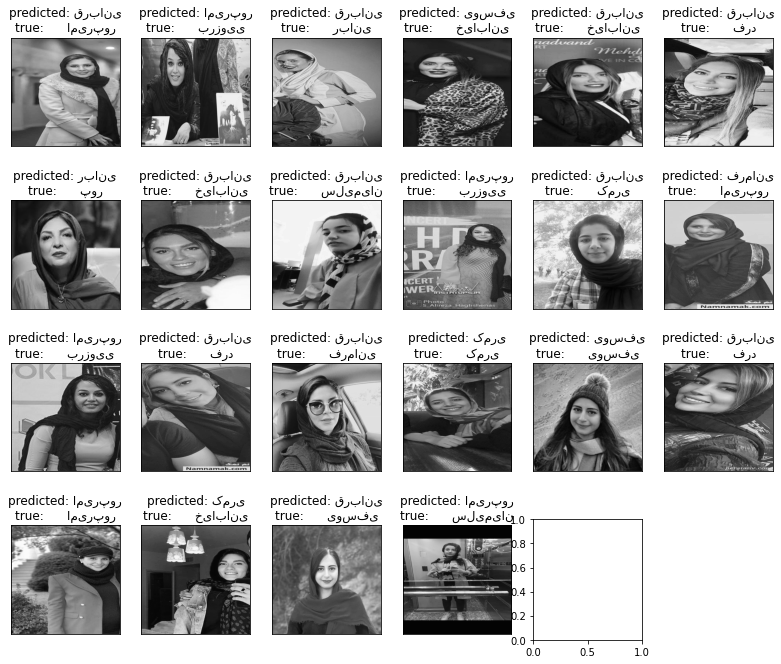

In [31]:
y_randomforest_pred = randomforest_clf.predict(X_test_pca)
print("""--------The results of RandomForestClassifier----------------""")
print(classification_report(y_test, y_randomforest_pred, target_names=target_names))
print(confusion_matrix(y_test, y_randomforest_pred, labels=range(n_classes)))

prediction_titles_RF = [title(y_randomforest_pred, y_test, target_names, i) for i in range(y_randomforest_pred.shape[0])]

plot_gallery(X_test, prediction_titles_RF, h, w)


--------The results of DecisionTreeClassifier----------------
                 precision    recall  f1-score   support

     آرزو یوسفی       0.17      0.50      0.25         2
  المیرا قربانی       0.00      0.00      0.00         0
   سارا سلیمیان       0.00      0.00      0.00         2
   سویل خیابانی       0.00      0.00      0.00         4
    عسل امیرپور       0.50      0.33      0.40         3
       غزل کمری       0.25      0.50      0.33         2
     لیلا ربانی       0.00      0.00      0.00         1
    مونا برزویی       0.00      0.00      0.00         3
نیلوفر لاری پور       0.00      0.00      0.00         1
 پریا پرتوی فرد       0.00      0.00      0.00         3
   یاسمن فرمانی       0.00      0.00      0.00         1

       accuracy                           0.14        22
      macro avg       0.08      0.12      0.09        22
   weighted avg       0.11      0.14      0.11        22

[[1 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0 0]
 [2 0

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\

IndexError: index 22 is out of bounds for axis 0 with size 22

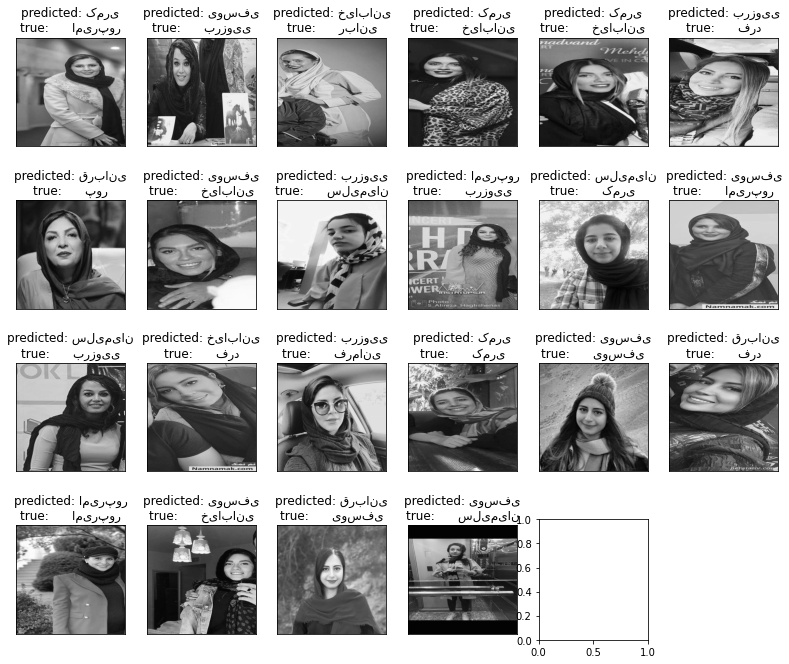

In [32]:
y_decisiontree_pred = decisiontree_clf.predict(X_test_pca)
print("""--------The results of DecisionTreeClassifier----------------""")
print(classification_report(y_test, y_decisiontree_pred, target_names=target_names))
print(confusion_matrix(y_test, y_decisiontree_pred, labels=range(n_classes)))

prediction_titles_DT = [title(y_decisiontree_pred, y_test, target_names, i) for i in range(y_decisiontree_pred.shape[0])]

plot_gallery(X_test, prediction_titles_DT, h, w)

--------The results of ExtraTreesClassifier----------------
                 precision    recall  f1-score   support

     آرزو یوسفی       0.33      0.50      0.40         2
  المیرا قربانی       0.00      0.00      0.00         0
   سارا سلیمیان       1.00      0.50      0.67         2
   سویل خیابانی       0.50      0.25      0.33         4
    عسل امیرپور       0.17      0.33      0.22         3
       غزل کمری       0.00      0.00      0.00         2
     لیلا ربانی       0.00      0.00      0.00         1
    مونا برزویی       0.00      0.00      0.00         3
نیلوفر لاری پور       0.00      0.00      0.00         1
 پریا پرتوی فرد       0.00      0.00      0.00         3
   یاسمن فرمانی       0.00      0.00      0.00         1

       accuracy                           0.18        22
      macro avg       0.18      0.14      0.15        22
   weighted avg       0.23      0.18      0.19        22

[[1 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0 0 0]
 [0 3 0

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\

IndexError: index 22 is out of bounds for axis 0 with size 22

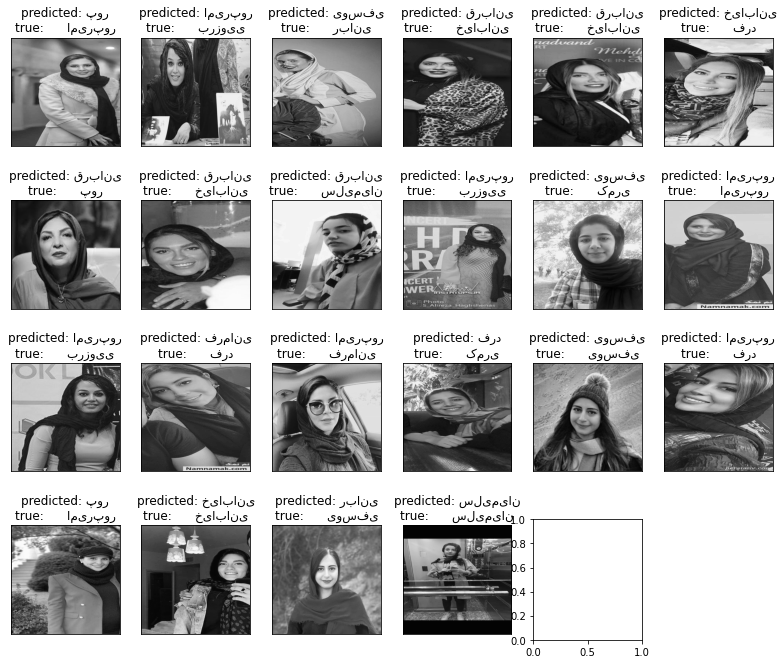

In [37]:
y_extratree_pred = extratree_clf.predict(X_test_pca)
print("""--------The results of ExtraTreesClassifier----------------""")
print(classification_report(y_test, y_extratree_pred, target_names=target_names))
print(confusion_matrix(y_test, y_extratree_pred, labels=range(n_classes)))

prediction_titles_ET = [title(y_extratree_pred, y_test, target_names, i) for i in range(y_extratree_pred.shape[0])]

plot_gallery(X_test, prediction_titles_ET, h, w)


--------The results of BaggingClassifier----------------
                 precision    recall  f1-score   support

     آرزو یوسفی       0.00      0.00      0.00         2
  المیرا قربانی       0.00      0.00      0.00         0
   سارا سلیمیان       0.67      1.00      0.80         2
   سویل خیابانی       0.00      0.00      0.00         4
    عسل امیرپور       0.17      0.67      0.27         3
       غزل کمری       0.00      0.00      0.00         2
     لیلا ربانی       0.00      0.00      0.00         1
    مونا برزویی       0.00      0.00      0.00         3
نیلوفر لاری پور       0.00      0.00      0.00         1
 پریا پرتوی فرد       0.00      0.00      0.00         3
   یاسمن فرمانی       0.00      0.00      0.00         1

       accuracy                           0.18        22
      macro avg       0.08      0.15      0.10        22
   weighted avg       0.08      0.18      0.11        22

[[0 1 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\

IndexError: index 22 is out of bounds for axis 0 with size 22

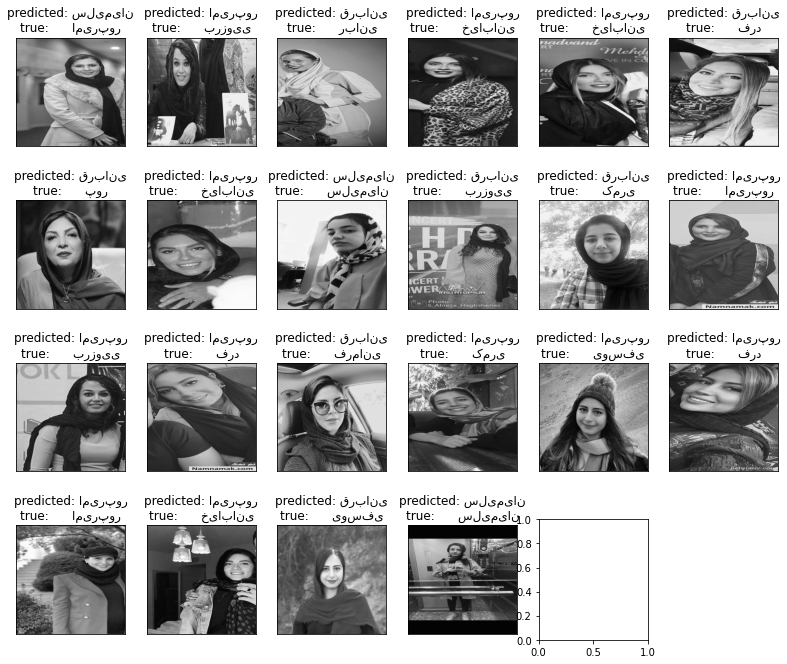

In [34]:
y_bagging_pred = bagging_clf.predict(X_test_pca)
print("""--------The results of BaggingClassifier----------------""")
print(classification_report(y_test, y_bagging_pred, target_names=target_names))
print(confusion_matrix(y_test, y_bagging_pred, labels=range(n_classes)))

prediction_titles_BG = [title(y_bagging_pred, y_test, target_names, i) for i in range(y_bagging_pred.shape[0])]

plot_gallery(X_test, prediction_titles_BG, h, w)


--------The results of VotingClassifier----------------
                 precision    recall  f1-score   support

     آرزو یوسفی       0.00      0.00      0.00         2
  المیرا قربانی       0.00      0.00      0.00         0
   سارا سلیمیان       0.00      0.00      0.00         2
   سویل خیابانی       0.00      0.00      0.00         4
    عسل امیرپور       0.29      0.67      0.40         3
       غزل کمری       0.00      0.00      0.00         2
     لیلا ربانی       0.00      0.00      0.00         1
    مونا برزویی       0.00      0.00      0.00         3
نیلوفر لاری پور       0.00      0.00      0.00         1
 پریا پرتوی فرد       0.00      0.00      0.00         3
   یاسمن فرمانی       0.00      0.00      0.00         1

       accuracy                           0.09        22
      macro avg       0.03      0.06      0.04        22
   weighted avg       0.04      0.09      0.05        22

[[0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0]
 [1 1 0 0 1

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\

IndexError: index 22 is out of bounds for axis 0 with size 22

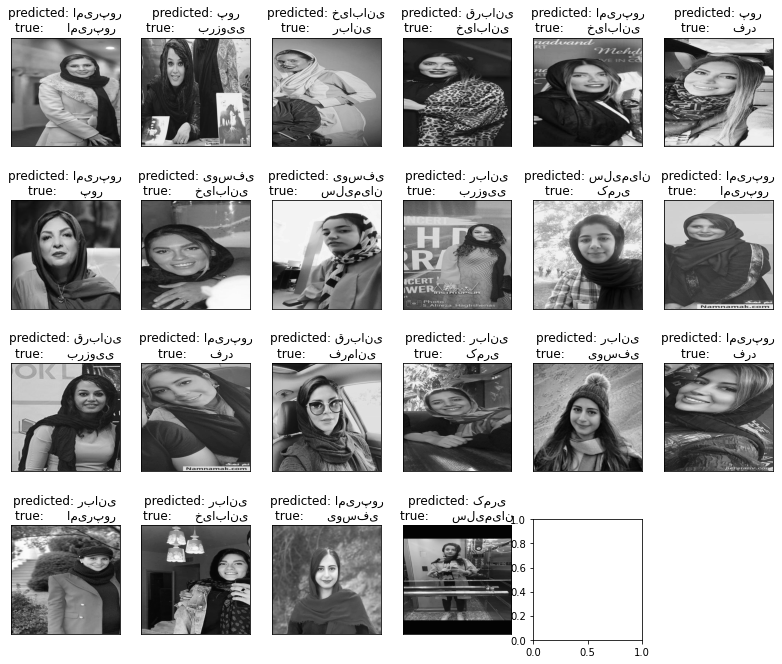

In [35]:
y_voting_pred = voting_clf.predict(X_test_pca)
print("""--------The results of VotingClassifier----------------""")
print(classification_report(y_test, y_voting_pred, target_names=target_names))
print(confusion_matrix(y_test, y_voting_pred, labels=range(n_classes)))


prediction_titles_VT = [title(y_voting_pred, y_test, target_names, i) for i in range(y_voting_pred.shape[0])]

plot_gallery(X_test, prediction_titles_VT, h, w)


--------The results of GradientBoostingClassifier----------------
                 precision    recall  f1-score   support

     آرزو یوسفی       0.00      0.00      0.00         2
  المیرا قربانی       0.00      0.00      0.00         0
   سارا سلیمیان       0.00      0.00      0.00         2
   سویل خیابانی       0.00      0.00      0.00         4
    عسل امیرپور       0.00      0.00      0.00         3
       غزل کمری       0.00      0.00      0.00         2
     لیلا ربانی       1.00      1.00      1.00         1
    مونا برزویی       0.00      0.00      0.00         3
نیلوفر لاری پور       0.00      0.00      0.00         1
 پریا پرتوی فرد       0.00      0.00      0.00         3
   یاسمن فرمانی       0.00      0.00      0.00         1

       accuracy                           0.05        22
      macro avg       0.09      0.09      0.09        22
   weighted avg       0.05      0.05      0.05        22

[[0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0]
 

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\

IndexError: index 22 is out of bounds for axis 0 with size 22

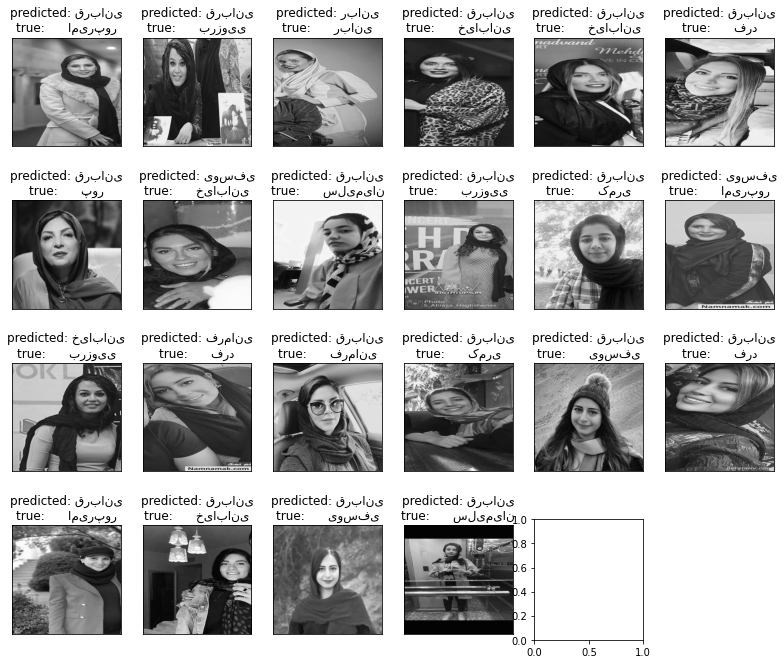

In [36]:
y_boosting_pred = boosting_clf.predict(X_test_pca)
print("""--------The results of GradientBoostingClassifier----------------""")
print(classification_report(y_test, y_boosting_pred, target_names=target_names))
print(confusion_matrix(y_test, y_boosting_pred, labels=range(n_classes)))

prediction_titles_BS = [title(y_boosting_pred, y_test, target_names, i) for i in range(y_boosting_pred.shape[0])]

plot_gallery(X_test, prediction_titles_BS, h, w)